In [1]:
from collections import namedtuple
from itertools import product
import warnings
import black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import wget
from geopy.distance import geodesic
from mlxtend.plotting import plot_decision_regions
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist, pdist
from scipy.stats import norm
from sklearn.cluster import (
    AgglomerativeClustering, DBSCAN, KMeans, MeanShift
)
from sklearn.datasets import make_blobs

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_theme(palette='tab10')

**Содержание**<a id='toc0_'></a>    
- [__Метод K-средних__](#toc1_)    
  - [__Описание алгоритма__](#toc1_1_)    
  - [__Способы начальной инициализации__](#toc1_2_)    
    - [__Инициализация наибольшим удалением__](#toc1_2_1_)    
    - [__K-means++__](#toc1_2_2_)    
  - [__K-средних руками__](#toc1_3_)    
  - [__Сравнение с sklearn на тех же данных__](#toc1_4_)    
  - [__Выбор числа $K$. Каменистая осыпь__](#toc1_5_)    
- [__Агломеративная (иерархическая) кластеризация__](#toc2_)    
  - [__Описание алгоритма__](#toc2_1_)    
  - [__Выбор функции расстояния__ $\rho$](#toc2_2_)    
  - [__Дендрограмма на игрушечном примере__](#toc2_3_)    
- [__DBSCAN (Density-Based Spatial Clustering of Applications with Noise)__](#toc3_)    
  - [__Описание алгоритма__](#toc3_1_)    
  - [__Чувствительность к радиусу $\varepsilon$-окрестности__](#toc3_2_)    
- [__Carnival Cruise Line__](#toc4_)    
  - [__K-средних__](#toc4_1_)    
  - [__DBSCAN__](#toc4_2_)    
  - [__MeanShift__](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
# <a id='toc1_'></a>[__Метод K-средних__](#toc0_)

Пусть $X \ne \varnothing$ - множество всех рассматриваемых объектов. Непустые множества $C_1,C_2,\dots,C_k \subset X$ называются __кластерами__, если их объединение совпадает с $X$, а пересечение любых двух из них с различными индексами есть пустое множество:

$$X = \bigcup_{i=1}^K C_i,$$

причем $C_i \cap C_j = \varnothing$ при $i \ne j, \; i,j \in \{1,2,\dots,K\}$.

Семейство множеств $C_1,C_2,\dots,C_k$ из определения выше называют __разбиением множества__ $X$.

Интуиция подсказывает, что кластеризация тем лучше, чем более "похожи" объекты в рамках одного кластера. Похожесть эквивалентна близости объектов с точки зрения расстояния между ними. Для случая отделенных шаровых сгустков можно сформулировать следующую эмпирическую характеристику "оптимальности": расстояние между любыми двумя объектами внутри одного кластера мало по сравнению с расстоянием между объектами, находящимися в двух разных кластерах. Разумно считать, что кластеризация проведена удачно, если среднее значение попарных расстояний между объектами одного кластера мало.

Область применения алгоритма K-средних невелика, она ограничивается жесткими предположениями на форму и расположение кластеров: плотные хорошо разделенные шаровые сгустки.

__Внутрикластерным расстоянием__ произвольного кластера называют сумму попарных расстояний между всеми объектами этого кластера.

__Среднее внутрикластерное расстояние__ - внутрикластерное расстояние, нормированное количеством пар объектов, принадлежащих кластеру.

__Центроидом__ кластера называется объект, $j$-ая координата которого получается усреднением (среднее арифметическое) $j$-ых координат [всех] объектов кластера.

При использовании в качестве функции расстояния квадрата евклидова расстояния среднее внутрикластерное расстояние в кластере равно удвоенной сумме квадратов расстояний от объектов кластера до центроида этого кластера:

In [3]:
random_state = 2128506
n, p = 1000, 50  # число объектов, число признаков
X = norm.rvs(size=(n,p), random_state=random_state)

In [4]:
pdist(X, 'sqeuclidean').sum() / (n/2)

100542.1149881977

In [5]:
c = X.mean(axis=0)  # центроид
cdist(X, c.reshape(1,-1), 'sqeuclidean').sum() * 2

100542.1149881977

In [6]:
(X.var(axis=0, ddof=n-1)).sum() * 2

100542.1149881977

Задача минимизации суммы средних внутрикластерных расстояний сводится к задаче минимизации суммы по всем кластерам квадратов расстояний от объектов кластера до центроида соответствующего кластера:
$$\Large \sum_{k=1}^K \sum_{x_i \in C_k} \sum_{j=1}^p (x_{ij} - \overline{x}_{kj})^2 \to \min.$$
Центроид на каждой итерации является чем-то вроде инварианта, относительно которого удобно следить за процессом кластеризации.

***
## <a id='toc1_1_'></a>[__Описание алгоритма__](#toc0_)

Пусть имеется набор данных $X = (x_1,x_2,\dots,x_n)$ объема $n$ с числовыми признаками, где
$$x_i = (x_{i1},x_{i2},\dots,x_{ip}), \quad i \in \{1,2,\dots,n\}.$$

1. Выбирается число $K \in \N$.
2. __Инициализация__. Каждый объект случайным образом относят к какому-то кластеру из набора $C_1,C_2,\dots,C_k$.
3. __Нахождение центроидов__. Для каждого кластера $C_k$ находят координаты центроида:
$$\overline{x}_k = (\overline{x}_{k1}, \overline{x}_{k2}, \dots, \overline{x}_{kp}), \quad \overline{x}_{kj} = \frac{1}{|C_k|} \sum_{x_i \in C_k} x_{ij},$$

$$k \in \{1,2,\dots,K\}, \; j \in \{1,2,\dots,p\}.$$

4. __Вычисление квадратов расстояний до центроидов__. Находят квадрат евклидова расстояния от $i$-ого объекта до центроида каждого кластера:
$$d^2_E (x_i,\overline{x}_k) = \sum_{j=1}^p (x_{ij} - \overline{x}_{kj})^2,$$

$$k \in \{1,2,\dots,K\}, \; i \in \{1,2,\dots,n\}.$$

5. __Перераспределение__. Объект $x_i$ относят к кластеру с наиболее близким к нему центроидом, то есть $x_i \in C_{k^*}$, где $k^*$ - любое из решений задачи
$$\argmin_{k \in \{1,2,\dots,K\}} d^2_E (x_i,\overline{x}_k).$$

Если среди решений поставленной задачи есть номер текущего кластера, то объект не меняет своей кластерной принадлежности.

6. Шаги 3-6 повторяются пока объекты не перестанут перераспределяться по кластерам.

Так как алгоритм K-средних использует для определения близости понятие расстояния, то __признаки кластеризуемых объектов перед началом кластеризации имеет смысл либо стандартизировать, либо нормировать__.

Описанный алгоритм сходится (то есть существует шаг, после которого объекты перестают перераспределяться по кластерам), поскольку нахождение новых центроидов на каждой итерации как минимум не увеличивает сумму квадратов расстояний до центроида внутри каждого кластера.

Ситуация, когда алгоритм сошелся, называется __локальным оптимумом__. Локальным потому, что результат кластеризации методом K-средних очень чувствителен к начальной инициализации (начального распределения объектов на кластеры или выбору начальных центроидов).

***
## <a id='toc1_2_'></a>[__Способы начальной инициализации__](#toc0_)

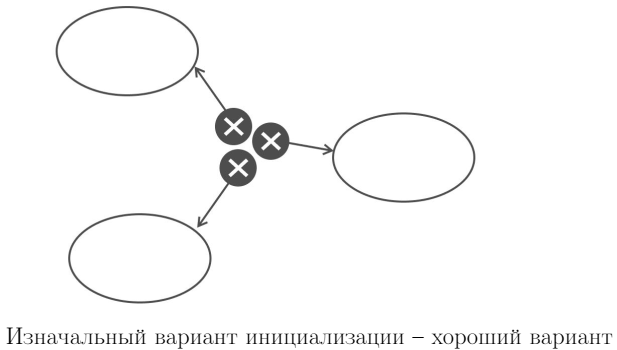

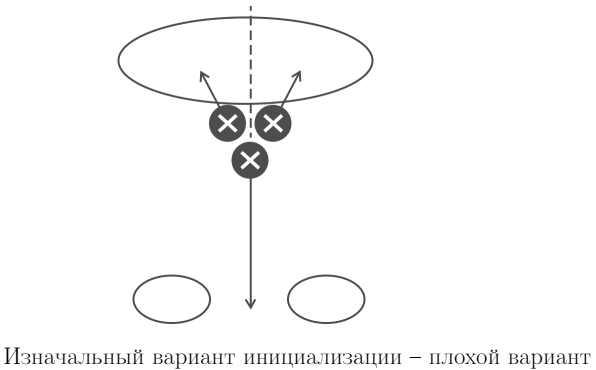

Два верхних центроида будут пытаться разбить большое облако на две части, а третий встанет посередине между двумя маленькими облаками, объединив их в один кластер.

Для исправления этой ситуации предложим два других (не единственных, но наиболее популярных) эмпрических подхода к начальной инициализации.

***
### <a id='toc1_2_1_'></a>[__Инициализация наибольшим удалением__](#toc0_)

1. В качестве первых двух центроидов берутся те два объекта исходных данных, которые расположены на наибольшем расстоянии друг от друга. Если таких пар несколько, выбирается любая.

2. Каждый следующий центроид, до $K$-ого включительно, выбирается таким образом, что расстояние от него до ближайшего из выбранных ранее центроидов максимально. Если претендентов несколько, выбирается любой из них.

Описанный способ пытается расположить центроиды как можно дальше друг от друга и разбросать их по пространству признаков $\R^p$ так, чтобы избежать ненужных склеек, объединений или, наоборот, разделений кластеров.

***
### <a id='toc1_2_2_'></a>[__K-means++__](#toc0_)

Данный подход похож на предыдущий и нацелен на внесение некоторой вероятностной подоплеки в описанный детерминизм. Алгоритм первоначального выбора $K$ центроидов таков:

1. Случайно выбранный объект исходного набора данных назначается первым центроидом.

2. Пусть выбрано $1 \le m \le K-1$ центроидов среди $n$ исходных данных. Перенумеруем оставшиеся данные, обозначив их $x_1,\dots,x_{n-m}$, и вычислим расстояние $d_i, \; i \in \{1,2,\dots,n-m\}$ от каждого из объектов до ближайшего центроида. Следующий центроид выбирается вероятностным образом, причем вероятность выбрать в качестве $(m+1)$-ого центроида объект $x_i$ равна
$$P(x_i) = \frac{d_i}{d_1 + d_2 + \dots + d_{n-m}}.$$

***
## <a id='toc1_3_'></a>[__K-средних руками__](#toc0_)

In [7]:
n_centers, random_state, seed = 5, 20, 7
# см. также (5, 7, 2), (5, 2, 7), (5, 0, 9)
aes = dict(s=70, edgecolor='w')

X, y = make_blobs(
    n_samples=1000, n_features=2,
    cluster_std=2,
    centers=n_centers,
    random_state=random_state
)

rng = np.random.default_rng(seed=seed)
rng.shuffle(y)

_"...Каждый следующий центроид, до $K$-ого включительно, выбирается таким образом, что расстояние от него до ближайшего из выбранных ранее центроидов максимально"_:

In [8]:
def init_centroids(X, n_centers, metric):
    centroids_indices = [*rng.choice(X.shape[0], 1)]
    for _ in range(n_centers - 1):
        dists = cdist(X, X[centroids_indices], metric)
        i = dists.min(axis=1).argmax()    
        centroids_indices.append(i)
    return X[centroids_indices]

In [9]:
def centroid(arr):
    return arr.mean(axis=0)

Несмещенная выборочная дисперсия (_sample variance_):
$$S^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \overline{x})^2$$

Чтобы не делить бесполезно на $(n-1)$ и тут же умножать на него, сразу скорректируем усредняющий множитель: 
$$S^2\bigl(\text{ddof}=n-1\bigr) = \frac{1}{n-n+1} \sum_{i=1}^n (x_i - \overline{x})^2 = \sum_{i=1}^n (x_i - \overline{x})^2.$$

См. атрибут __`inertia_`__ в [__sklearn.cluster.KMeans__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn-cluster-kmeans).

Если использовать механическую интерпретацию распределения случайной величины, то ее дисперсия представляет собой __момент инерции__ распределения масс относительно центра масс (математического ожидания).

In [10]:
def cluster_inertia(arr):
    ddof = arr.shape[0] - 1  # отмена нормировки
    return (arr.var(axis=0, ddof=ddof)).sum()

In [11]:
def plot_clusters(X, y, centroids):
    plt.figure(figsize=(9,6))
    plt.scatter(*X.T, c=y, cmap='tab10', **aes)
    plt.scatter(*centroids.T, c='r', **aes)
    plt.show()

In [12]:
fields = 'iteration', 'labels', 'centroids', 'inertia'
KMeansIterationReport = namedtuple('KMeansIterationReport', fields)

In [13]:
def print_black(collection):
    print(black.format_str(repr(collection), mode=black.Mode()))

In [14]:
def kmeansHandmade(X, y, n_centers=n_centers, metric='sqeuclidean'):
    centroids = init_centroids(X, n_centers, metric)
    plot_clusters(X, y, centroids)  # initial state
    i = 0
    
    while True:
        y_ = np.argmin(cdist(X, centroids, metric), 1)
        if np.all(y_ == y):
            break
        y = y_; i += 1
        
        labels, counts = np.unique(y, return_counts=True)
        labels_counts = dict(zip(labels, counts))
        centroids, inertia = [], 0
        
        for label in labels:
            cluster = X[y == label]
            centroids.append(centroid(cluster))
            inertia += cluster_inertia(cluster)
        
        centroids = np.asarray(centroids)
        plot_clusters(X, y, centroids)
        
        report = KMeansIterationReport(i, labels_counts, centroids, inertia)
        print_black(report)

Комментарий к первому графику ниже. Цвета объектов только для демонстрации перемешивания меток. Знание кластерной принадлежности объектов при запуске не используется - используются начальные центроиды из __`init_centroids`__.

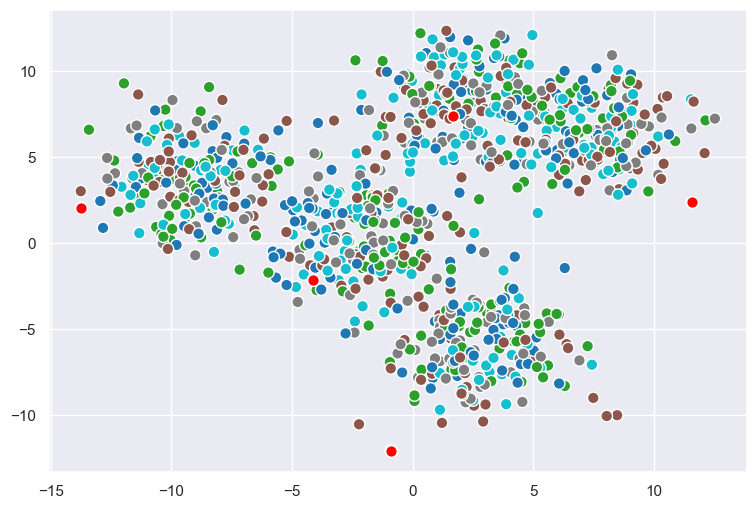

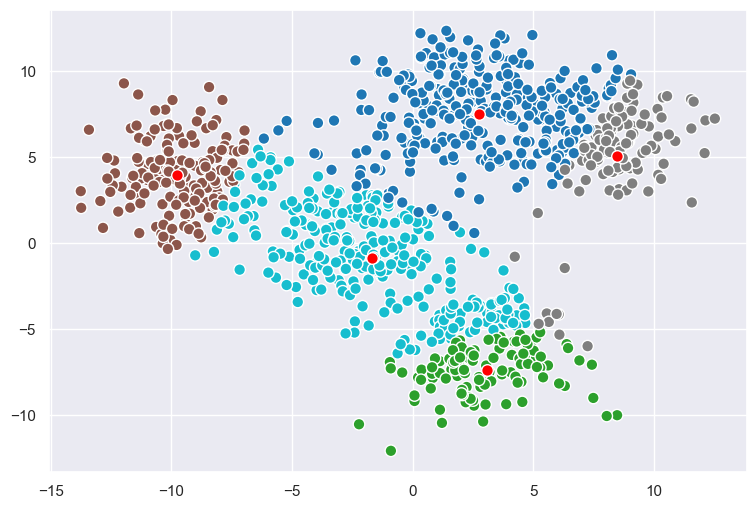

KMeansIterationReport(
    iteration=1,
    labels={0: 318, 1: 113, 2: 164, 3: 116, 4: 289},
    centroids=array(
        [
            [2.75130616, 7.50418977],
            [3.08092636, -7.39871975],
            [-9.76083558, 3.97572375],
            [8.47415948, 5.03804471],
            [-1.68256349, -0.84749244],
        ]
    ),
    inertia=12307.877357695877,
)



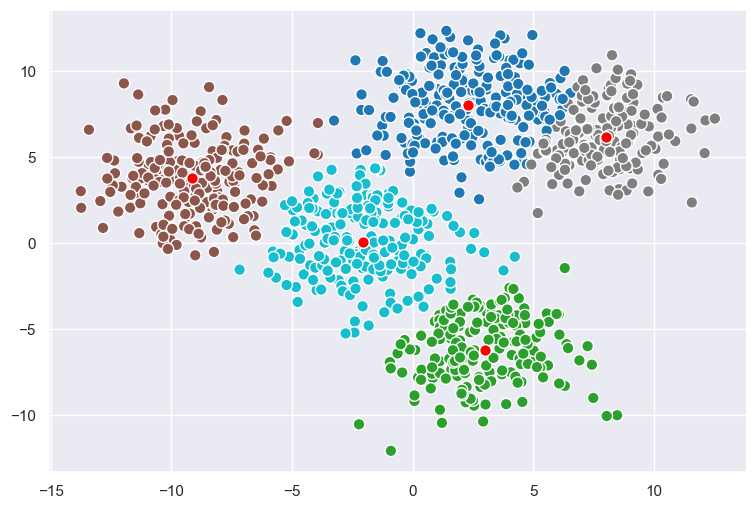

KMeansIterationReport(
    iteration=2,
    labels={0: 237, 1: 186, 2: 202, 3: 163, 4: 212},
    centroids=array(
        [
            [2.286049, 8.05127091],
            [2.99274583, -6.23653441],
            [-9.16239825, 3.80874273],
            [8.01390478, 6.17293688],
            [-2.05132885, 0.08525015],
        ]
    ),
    inertia=7435.140030683473,
)



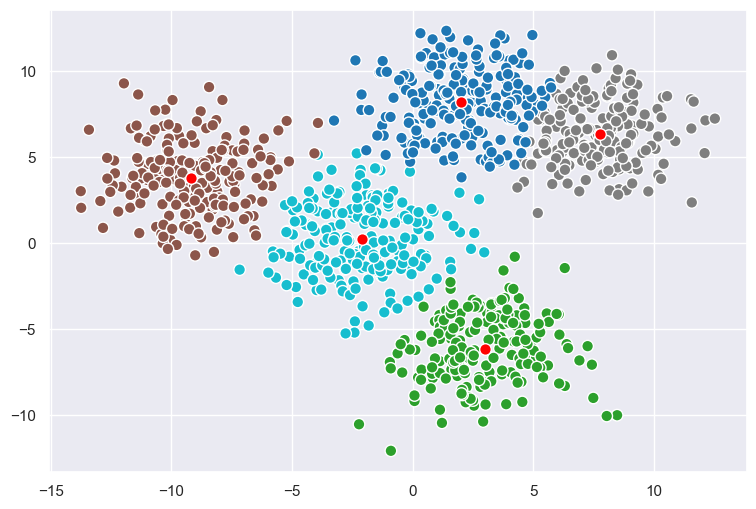

KMeansIterationReport(
    iteration=3,
    labels={0: 213, 1: 191, 2: 201, 3: 183, 4: 212},
    centroids=array(
        [
            [2.00160251, 8.18091524],
            [2.97498945, -6.13100183],
            [-9.18840784, 3.80212918],
            [7.75665238, 6.32225328],
            [-2.11385412, 0.23146069],
        ]
    ),
    inertia=7260.182416910701,
)



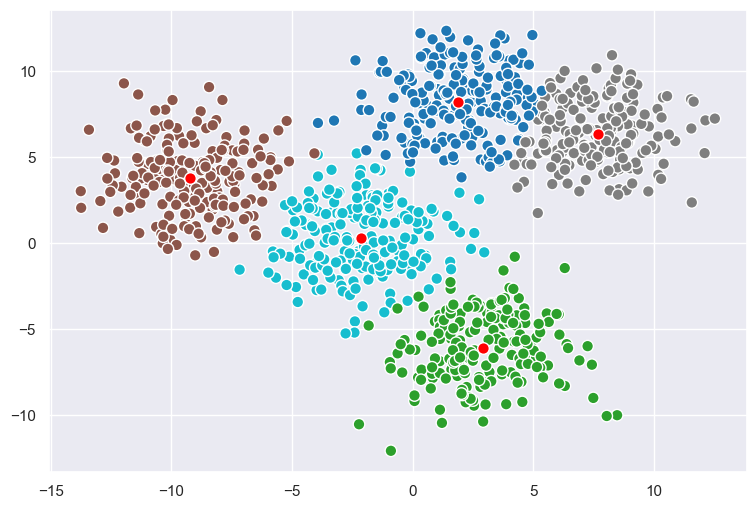

KMeansIterationReport(
    iteration=4,
    labels={0: 207, 1: 194, 2: 200, 3: 190, 4: 209},
    centroids=array(
        [
            [1.86841706, 8.20804566],
            [2.91757076, -6.09660804],
            [-9.21471328, 3.78623618],
            [7.65852142, 6.35485565],
            [-2.133602, 0.29086257],
        ]
    ),
    inertia=7232.009804823627,
)



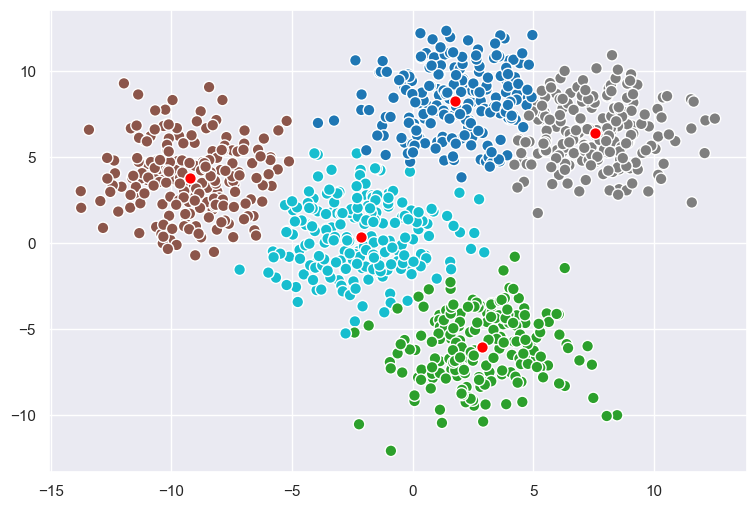

KMeansIterationReport(
    iteration=5,
    labels={0: 200, 1: 197, 2: 199, 3: 197, 4: 207},
    centroids=array(
        [
            [1.76704605, 8.24570213],
            [2.86073648, -6.06295388],
            [-9.24054486, 3.77905903],
            [7.5556964, 6.38247513],
            [-2.16209375, 0.3751919],
        ]
    ),
    inertia=7219.226139212371,
)



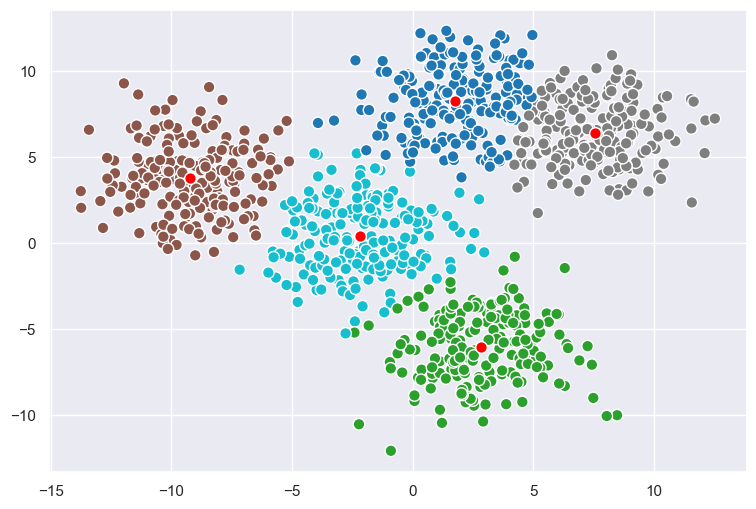

KMeansIterationReport(
    iteration=6,
    labels={0: 199, 1: 198, 2: 199, 3: 198, 4: 206},
    centroids=array(
        [
            [1.75291609, 8.2532688],
            [2.84521427, -6.04929295],
            [-9.24054486, 3.77905903],
            [7.54066212, 6.38428048],
            [-2.17155702, 0.39331462],
        ]
    ),
    inertia=7216.798374045959,
)



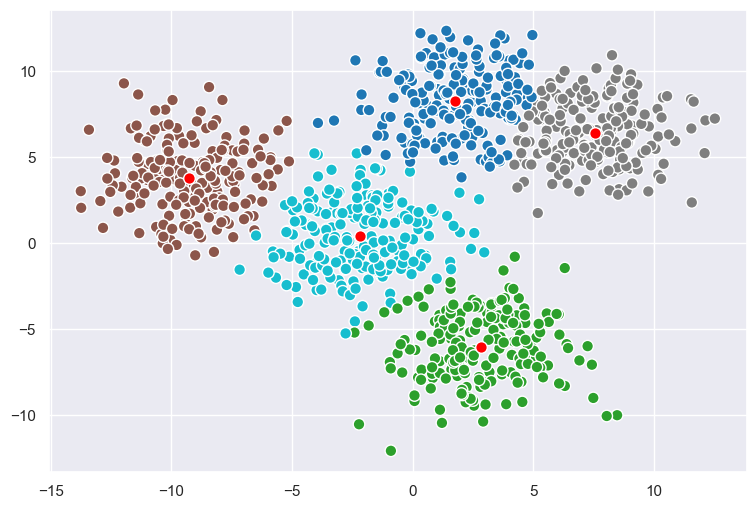

KMeansIterationReport(
    iteration=7,
    labels={0: 199, 1: 199, 2: 198, 3: 198, 4: 206},
    centroids=array(
        [
            [1.75291609, 8.2532688],
            [2.82499033, -6.03912563],
            [-9.25442353, 3.79595258],
            [7.54066212, 6.38428048],
            [-2.19734934, 0.41496575],
        ]
    ),
    inertia=7216.077163327435,
)



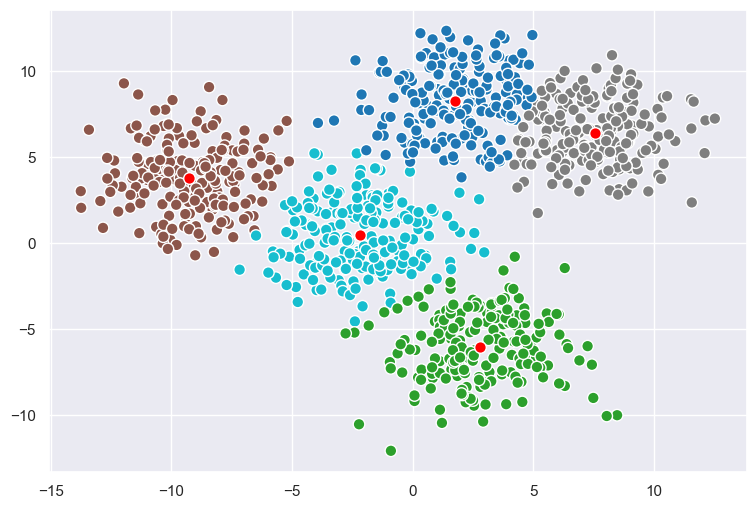

KMeansIterationReport(
    iteration=8,
    labels={0: 199, 1: 200, 2: 198, 3: 198, 4: 205},
    centroids=array(
        [
            [1.75291609, 8.2532688],
            [2.79695411, -6.03520314],
            [-9.25442353, 3.79595258],
            [7.54066212, 6.38428048],
            [-2.19449615, 0.4426223],
        ]
    ),
    inertia=7215.328633379084,
)



In [15]:
kmeansHandmade(X, y)

***
## <a id='toc1_4_'></a>[__Сравнение с sklearn на тех же данных__](#toc0_)

In [16]:
fields = 'n_iters', 'labels', 'centroids', 'inertia'
KMeansSklearnReport = namedtuple('KMeansSklearnReport', fields)

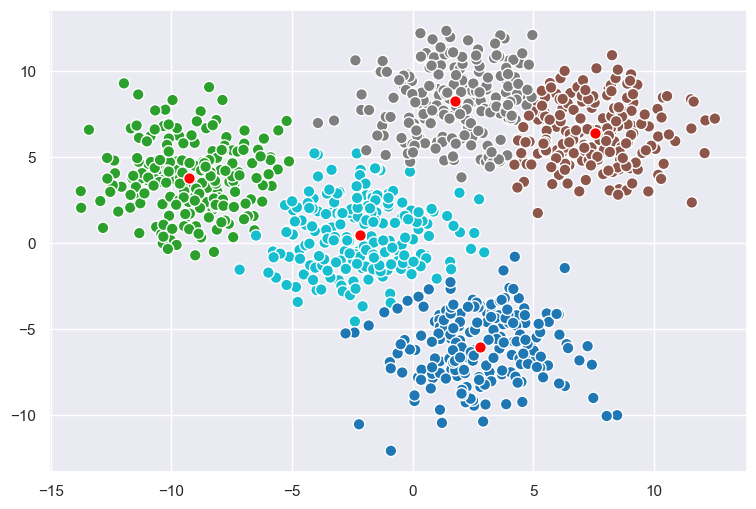

KMeansSklearnReport(
    n_iters=6,
    labels={0: 200, 1: 198, 2: 198, 3: 199, 4: 205},
    centroids=array(
        [
            [2.79695411, -6.03520314],
            [-9.25442353, 3.79595258],
            [7.54066212, 6.38428048],
            [1.75291609, 8.2532688],
            [-2.19449615, 0.4426223],
        ]
    ),
    inertia=7215.328633379084,
)



In [17]:
km = KMeans(n_centers, n_init='auto', random_state=random_state).fit(X)
plot_clusters(X, km.labels_, km.cluster_centers_)

labels = dict(zip(*np.unique(km.labels_, return_counts=True)))
report = KMeansSklearnReport(km.n_iter_, labels, km.cluster_centers_, km.inertia_)
print_black(report)

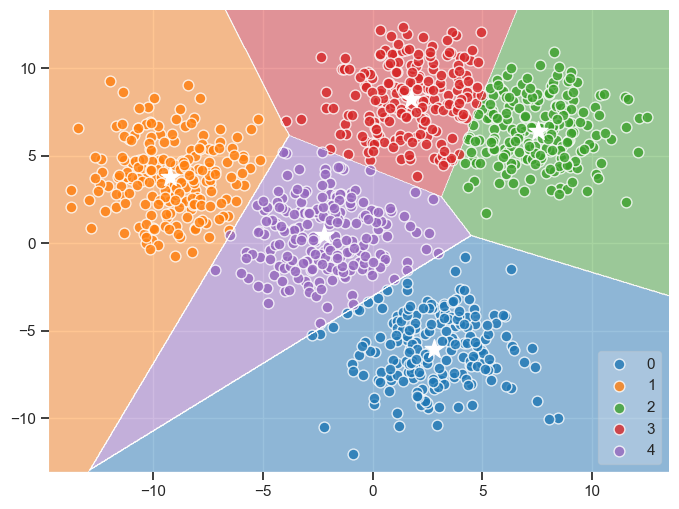

In [18]:
plt.figure(figsize=(8,6))
plot_decision_regions(X, km.labels_, km, markers='o', legend=4,
                      scatter_kwargs={'s': 60, 'edgecolor': 'w'},
                      contour_kwargs={'colors': 'w'})
plt.scatter(*km.cluster_centers_.T, marker='*', s=200, c='w')
plt.show()

***
## <a id='toc1_5_'></a>[__Выбор числа $K$. Каменистая осыпь__](#toc0_)

Гарантированно верного ответа о правильном количестве кластеров дать нельзя. Однако можно отследить качество кластеризации при помощи т.н. _каменистой осыпи_ или _локтя_.

__Каменистой осыпью__ или __локтем__ называется график зависимости инерции (суммы квадратов расстояний от объектов кластера до центроида этого кластера по всем кластерам) от количества кластеров $K$.

In [19]:
def sklearnInertia(X, k):
    return KMeans(k, n_init='auto', random_state=random_state).fit(X).inertia_

In [20]:
def plotElbow(X, K, descr=''):
    inertia = [sklearnInertia(X, k) for k in K]
    title = 'График каменистой осыпи'
    if descr: title += f': {descr}'
    plt.figure(figsize=(8,4))
    plt.plot(K, inertia, marker='o')
    plt.xticks(K)
    plt.xlabel('Число кластеров, $K$')
    plt.ylabel('$Inertia(K)$')
    plt.title(title)
    plt.show()

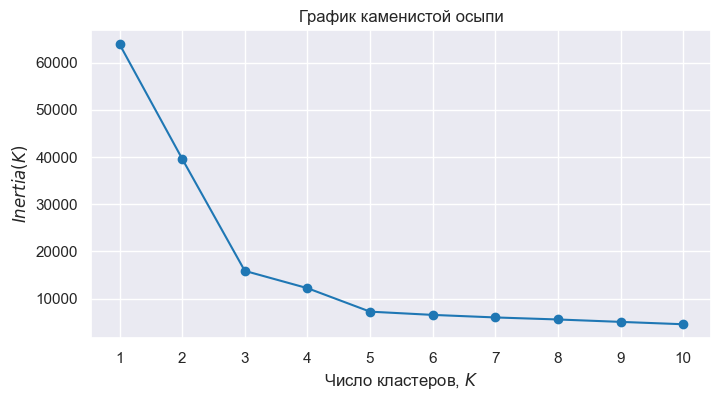

In [21]:
plotElbow(X, range(1, 11))

Группу значений $K$, при которых прекращается резкий спад, и стоит рассматривать как предположительно наиболее удачные значения числа кластеров. Выбор единственного значения из группы следует делать после кластеризации при соответствующем $K$ и интерпретации результата с точки зрения предметной области. 

***
# <a id='toc2_'></a>[__Агломеративная (иерархическая) кластеризация__](#toc0_)

__Достоинства метода__:
* вычислительная простота;
* не требуется априоирное задание числа кластеров;
* наглядность, простота визуализации результатов;
* умеет находить ленточные кластеры.

***
## <a id='toc2_1_'></a>[__Описание алгоритма__](#toc0_)

Пусть имеется набор данных $X = (x_1,x_2,\dots,x_n)$ объема $n$.

1. Выбирается функция расстояния $\rho(X,Y)$, отражающая похожесть (близость) кластеров $X$ и $Y$.

2. Каждый объект $x_i, \; i \in \{1,2,\dots,n\}$ помещается в отдельный кластер:
$$C_1=\{x_1\}, \; C_2=\{x_2\}, \; \dots, \; C_n=\{x_n\}.$$

3. Пусть имеется $K > 1$ кластеров. Ищутся два наиболее похожих относительно выбранной функции расстояния $\rho$ кластера и объединяются между собой. Остальные кластеры остаются неизменными. В случае, если кандидатов (пар) на объединение несколько, объединяется любая пара кандидатов. В итоге остается $(K-1)$ кластер.

4. Шаг 3 повторяется пока количество кластеров не станет равным $1$.

***
## <a id='toc2_2_'></a>[__Выбор функции расстояния__ $\rho$](#toc0_)

Пусть кластер $X$ состоит из элементов $x_1,x_2,\dots,x_s$, а кластер $X'$ - из элементов $x'_1,x'_2,\dots,x'_r$, причем все элементы кластеров принадлежат пространству $\R^p$, то есть описываются $p$ числовыми признаками-предикторами. Пусть также $d$ - некоторая функция расстояния, показывающая схожесть объектов из $\R^p$. Покажем несколько основных приемов определения расстояния между кластерами $X$ и $X'$.

1. __Метод полной связи (метод дальнего соседа)__, хорошо выделяющий плотные шаровые сгустки:
$$\rho(X,X') = \max_{x \in X, x' \in X'} d(x,x')$$

2. __Метод одиночной связи (метод ближайшего соседа)__, хорошо выделяющий ленточные кластеры:
$$\rho(X,X') = \min_{x \in X, x' \in X'} d(x,x')$$

3. __Метод средней связи (среднее невзвешенное расстояние)__, хорошо выделяющий плотные шаровые сгустки. В качестве расстояния между кластерами принимается среднее арифметическое всех попарных расстояний между элементами соответствующих кластеров:
$$\rho(X,X') = \frac{1}{|X| \cdot |X'|} \sum_{x \in X} \sum_{x' \in X'} d(x,x')$$

4. __Центроидный (центроидальный) метод__, также хорошо выделяющий плотные шаровые сгустки, однако редко применяющийся из-за возможных самопересечений в дендрограмме:
$$\rho(X,X') = d(\overline{x},\overline{x}')$$

5. __Метод Варда (Уорда)__. В качестве расстояния $\rho(X,X')$ принимается величина, показывающая изменение суммы квадратов расстояний от элементов кластера до центроида до и после объединения:
$$\rho(X,X') = \sum_{x \in X \cup X'} d^2_E (x,\overline{x}_{\cup}) - \sum_{x \in X} d^2_E (x,\overline{x}) - \sum_{x' \in X'} d^2_E (x',\overline{x}') = $$

$$= \frac{|X||X'|}{|X| + |X'|} d^2_E (\overline{x},\overline{x}'),$$

где первое слагаемое - сумма квадратов расстояний от объектов объединенного кластера до центроида этого кластера. В методе Варда расстояние между кластерами показывает что-то вроде изменения "плотности" кластера при объединении двух кластеров. Использовать в методе Варда нужно именно евклидово расстояние.

***
## <a id='toc2_3_'></a>[__Дендрограмма на игрушечном примере__](#toc0_)

In [22]:
data = np.array([[10, 1], [7, 4], [8, 3], [2, 2], [1, 5],
                 [3, 3], [2, 1], [3, 2], [2, 8], [9, 8],
                 [4, 10], [2, 9], [3, 7], [8, 7], [6, 9]],
                dtype=float)

food = ['banana', 'oranges', 'grapes', 'shrimp', 'bacon',
        'nuts', 'cheese', 'fish', 'cucumber', 'apple',
        'carrot', 'celery', 'salad', 'pear', 'pepper']

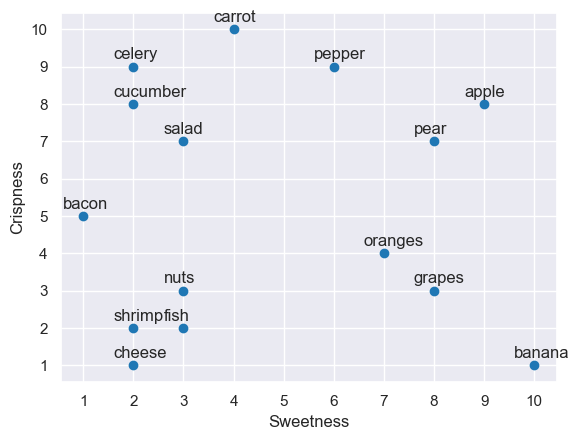

In [23]:
plt.scatter(*data.T)
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))
plt.xlabel('Sweetness')
plt.ylabel('Crispness')
for label, coords in zip(food, data):
    coords += np.array([-0.4, 0.2])
    plt.annotate(label, xy=coords)
plt.show()

[__scipy.cluster.hierarchy.linkage__](https://scipy.github.io/devdocs/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy-cluster-hierarchy-linkage) | [__scipy.cluster.hierarchy.dendrogram__](https://scipy.github.io/devdocs/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy-cluster-hierarchy-dendrogram)

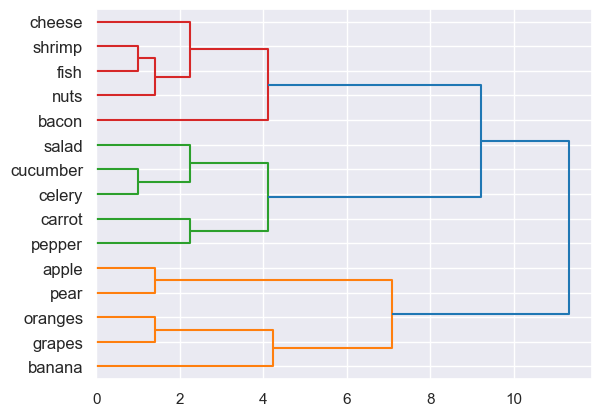

In [24]:
Z = linkage(data, 'complete', optimal_ordering=True)
dn = dendrogram(Z, labels=food, orientation='right')

[__sklearn.cluster.AgglomerativeClustering__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn-cluster-agglomerativeclustering)

In [25]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete')
clustering.fit(data)
clustering.labels_

array([0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2], dtype=int64)

In [26]:
mapping = dict(zip(range(3), ['fruit', 'protein', 'vegetable']))
trans = np.vectorize(lambda label: mapping[label])
dict(zip(food, trans(clustering.labels_)))

{'banana': 'fruit',
 'oranges': 'fruit',
 'grapes': 'fruit',
 'shrimp': 'protein',
 'bacon': 'protein',
 'nuts': 'protein',
 'cheese': 'protein',
 'fish': 'protein',
 'cucumber': 'vegetable',
 'apple': 'fruit',
 'carrot': 'vegetable',
 'celery': 'vegetable',
 'salad': 'vegetable',
 'pear': 'fruit',
 'pepper': 'vegetable'}

Сравни атрибуты:

*The children of each non-leaf node. Values less than n_samples correspond to leaves of the tree which are the original samples. A node i greater than or equal to n_samples is a non-leaf node and has children children_[i - n_samples]. Alternatively at the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i.*

In [27]:
clustering.children_

array([[ 8, 11],
       [ 3,  7],
       [ 9, 13],
       [ 1,  2],
       [ 5, 16],
       [12, 15],
       [10, 14],
       [ 6, 19],
       [20, 21],
       [ 4, 22],
       [ 0, 18],
       [17, 25],
       [23, 24],
       [26, 27]])

*A $(n-1)$ by 4 matrix Z is returned. At the $i$-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster $n+i$. A cluster with an index less than $n$ corresponds to one of the $n$ original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.*

In [28]:
Z

array([[11.        ,  8.        ,  1.        ,  2.        ],
       [ 7.        ,  3.        ,  1.        ,  2.        ],
       [13.        ,  9.        ,  1.41421356,  2.        ],
       [ 2.        ,  1.        ,  1.41421356,  2.        ],
       [ 5.        , 16.        ,  1.41421356,  3.        ],
       [15.        , 12.        ,  2.23606798,  3.        ],
       [14.        , 10.        ,  2.23606798,  2.        ],
       [19.        ,  6.        ,  2.23606798,  4.        ],
       [21.        , 20.        ,  4.12310563,  5.        ],
       [ 4.        , 22.        ,  4.12310563,  5.        ],
       [ 0.        , 18.        ,  4.24264069,  3.        ],
       [25.        , 17.        ,  7.07106781,  5.        ],
       [23.        , 24.        ,  9.21954446, 10.        ],
       [26.        , 27.        , 11.3137085 , 15.        ]])

***
# <a id='toc3_'></a>[__DBSCAN (Density-Based Spatial Clustering of Applications with Noise)__](#toc0_)

Плотностный алгоритм пространственной кластеризации с присутствием шума. Идея следует из названия: объекты составляют кластер, если они плотно расположены друг к другу. _Плотно_ означает, что рядом с каждым объектом кластера есть достаточно много соседей - элементов того же кластера.

DBSCAN успешно справляется с нахождением как плотных шаровых сгустков, так и ленточных кластеров. При фиксированных параметрах модели количество кластеров определяется однозначным образом.

Пусть имеется набор данных $X = (x_1,x_2,\dots,x_n)$ объема $n$, причем $x_i \in \R^p, \; i \in \{1,2,\dots,n\}$, то есть каждый объект описывается $p$ числовыми признаками. Пусть $d$ - выбранная функция расстояния в $\R^p$.

Пусть $\varepsilon > 0, \; x_0 \in X$. Множество
$$B_X (x_0,\varepsilon) = \{y \in X: d(x_0,y) \le \varepsilon\}$$
называется __замкнутым шаром__ в $X$ с центром в $x_0$ и радиуса $\varepsilon$.

Элементы замкнутого шара с центром в $x_0$ называются __соседями__ элемента $x_0$, то есть соседи элемента $x_0 \in X$ - это точки из $X$, лежащие в замкнутой $\varepsilon$-окрестности точки $x_0$.

Пусть $m \in \N$ - некоторое наперед заданное число. Если
$$|B(x_0,\varepsilon)| \ge m,$$
то объект $x_0$ называется __корневым объектом__, то есть корневой объект это объект, у которого как минимум $m$ штук соседей, включая его самого.

***
## <a id='toc3_1_'></a>[__Описание алгоритма__](#toc0_)

1. Выбирается $\varepsilon > 0, \; m \in \N$. Пусть $i = 1$.
2. Находится какой-нибудь корневой объект $x$ в $X$. Если корневых объектов нет, переход к п.7.
3. Все соседи объекта $x$ помещаются в кластер $C_i$.
4. Для каждого элемента из $C_i$ проверяется, является ли он корневым. Если является, то все соседи найденного корневого элемента добавляются к $C_i$.
5. п.4 повторяется до тех пор, пока состав кластера $C_i$ не перестанет изменяться.
6. Полагается $X = X \setminus C_i, \; i = i + 1$. Переход к п.2.
7. Все объекты множества $X$, если они есть, помещаются в отдельный кластер - выбросы. Кластеризация завершена.

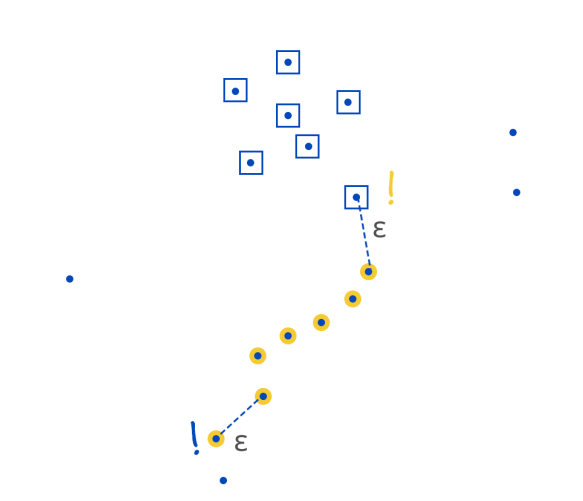

Пусть $m = 3$.

Объект с желтым восклицательным знаком попал к синим квадратам только за счет того, что первым был выбран корневой элемент, сформировавший синий кластер.

Объект с синим восклицательным знаком не является корневым, поскольку в окружающем его шаре радиуса $\varepsilon$ лишь две точки, принадлежащие желтому кластеру. Поэтому нижняя точка на рисунке не попадает в желтый кластер.

Так как больше не осталось ранее не рассмотренных корневых точек, то все объекты, нарисованные синими точками, $4$ штуки, - это __выбросы__, или __шум__.

При фиксированных параметрах алгоритма $m$ и $\varepsilon$ корневые элементы, если они есть, а также выбросы, распределяются по кластерам однозначным образом. __Граничные объекты__ - не корневые объекты и не являющиеся выбросами - могут менять свою кластерную принадлежность в зависимости от порядка выбора корневых элементов, при перезапуске алгоритма даже с неизменными параметрами.

***
## <a id='toc3_2_'></a>[__Чувствительность к радиусу $\varepsilon$-окрестности__](#toc0_)

In [29]:
n_centers, random_state = 3, 42
n_samples = 2, 5, 10
epsilon = 0.2, 1, 3, 5, 10

X, _ = make_blobs(
    n_samples=600, n_features=2,
    centers=n_centers,
    random_state=random_state
)

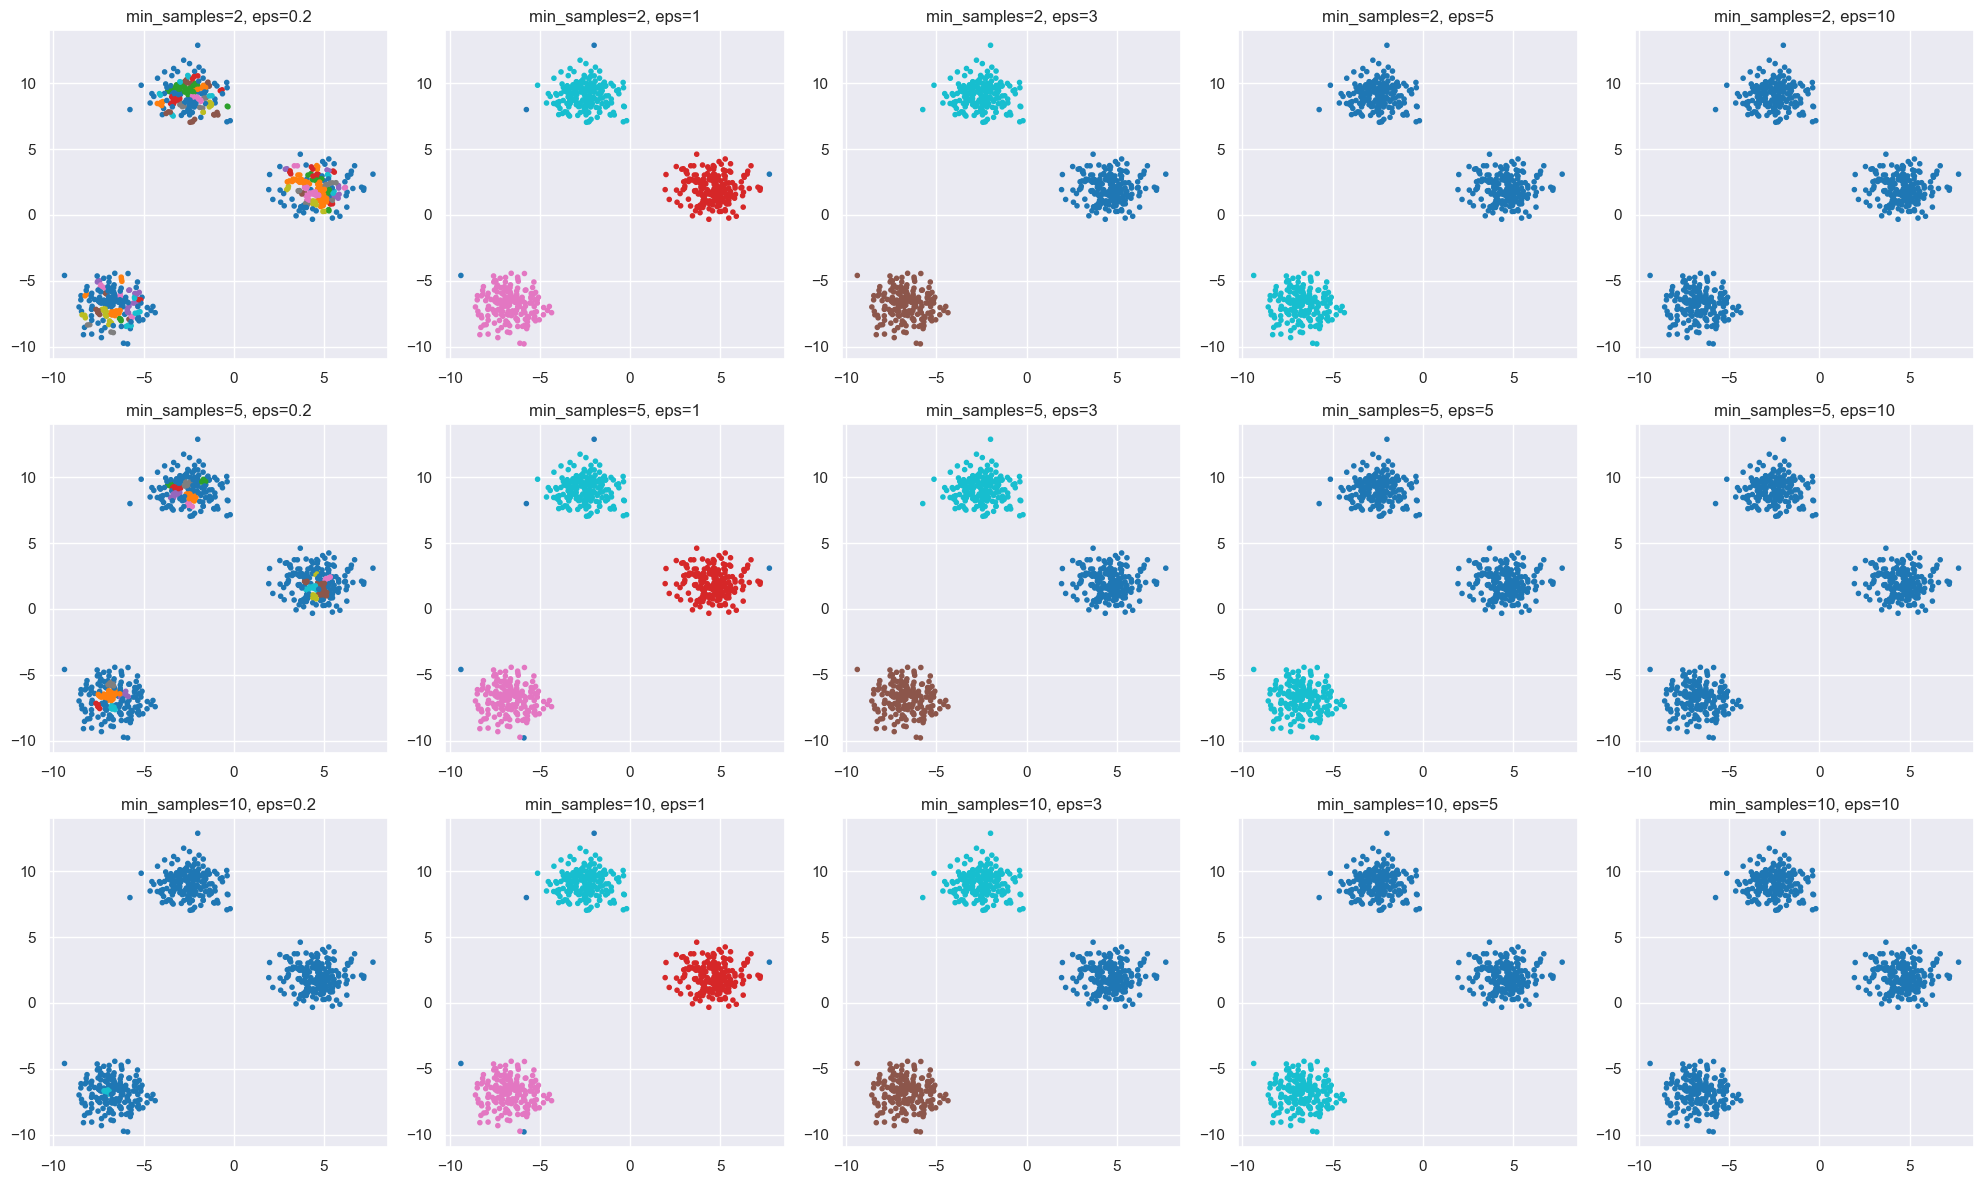

In [30]:
axs = plt.subplots(len(n_samples), len(epsilon), figsize=(20,12))[1]
it = axs.flat

for min_samples, eps in product(n_samples, epsilon):
    dbscan = DBSCAN(eps, min_samples=min_samples).fit(X)
    ax = next(it)
    ax.scatter(*X.T, marker='.', c=dbscan.labels_, cmap='tab10')
    ax.set_title(f'{min_samples=}, {eps=}')
    
plt.tight_layout()
plt.show()

In [31]:
eps, noise_ratio = 0.05, 1
clusters_number_log, noise_ratio_log, eps_log = [], [], []

while noise_ratio > 0.1:
    dbscan = DBSCAN(eps).fit(X)    
    # метка "-1" зарезервирована для шума: https://bit.ly/3zB23Ss
    clusters_number_log.append(len(set(dbscan.labels_)) - 1)
    noise_ratio = np.sum(dbscan.labels_ == -1) / dbscan.labels_.size
    noise_ratio_log.append(noise_ratio)
    eps_log.append(eps)
    eps += 0.05

[__matplotlib.axes.Axes.twinx__](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html#matplotlib-axes-axes-twinx)

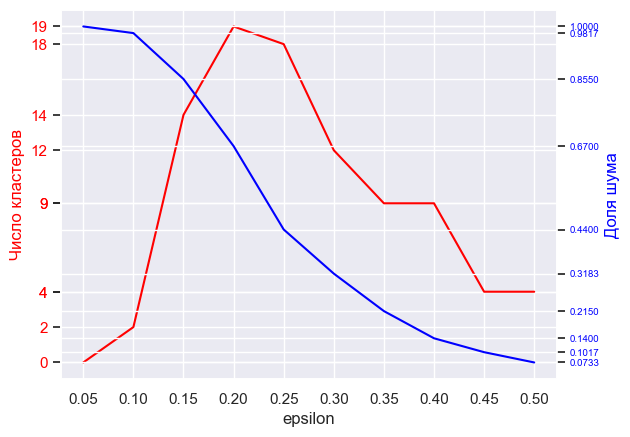

In [32]:
plt.plot(eps_log, clusters_number_log, c='r')
plt.xticks(eps_log)
plt.yticks(clusters_number_log)
plt.xlabel('epsilon')
plt.ylabel('Число кластеров', c='r')
plt.tick_params(axis='y', labelcolor='r')
ax = plt.gca().twinx()
ax.plot(eps_log, noise_ratio_log, c='b')
ax.set_yticks(noise_ratio_log)
ax.set_ylabel('Доля шума', c='b')
ax.tick_params(axis='y', labelsize=7, labelcolor='b')
plt.show()

***
# <a id='toc4_'></a>[__Carnival Cruise Line__](#toc0_)

Международное круизное агентство Carnival Cruise Line решило разместить $20$ рекламных баннеров вблизи своих офисов по всему миру. Необходимо выбрать эффективные локации.

Логично разместить баннеры в местах интенсивного трафика путешественников. Такие места можно найти по геолокации - по базе чекинов Foursquare. Кластеризуем чекины, найдем популярные места в окрестностях офисов.

In [33]:
#wget.download('https://raw.githubusercontent.com/FUlyankin/ML_for_marketing/master/drafts/sem9_clasters/hw6/checkins.csv')

In [34]:
df = pd.read_csv('checkins.csv')
df.head()

id    user_id  venue_id   latitude   longitude            created_at
0  984222    15824.0    5222.0  38.895112  -77.036366   2012-04-21 17:43:47
1  984234    44652.0    5222.0  33.800745  -84.410520   2012-04-21 17:43:43
2  984291   105054.0    5222.0  45.523452 -122.676207   2012-04-21 17:39:22
3  984318  2146539.0    5222.0  40.764462 -111.904565   2012-04-21 17:35:46
4  984232    93870.0  380645.0  33.448377 -112.074037   2012-04-21 17:38:18

* __`id`__ - id наблюдения;
* __`user_id`__ - id пользователя в Foursquare;
* __`venue_id`__ - id места, где произошел чекин (рестораны, достопримечательности и т.п.);
* __`latitude`__, __`longitude`__ - координаты чекина;
* __`created_at`__ - время чекина.

In [35]:
df.shape

(396634, 6)

In [36]:
X = df[['longitude', 'latitude']].values

In [37]:
offices_cities = ['Los Angeles', 'Miami', 'London', 
                  'Amsterdam', 'Beijing', 'Sydney']

offices_coords = np.array([[-118.188740, 33.751277], 
                           [-80.324116, 25.867736], 
                           [-0.075479, 51.503016],
                           [4.885084, 52.378894], 
                           [117.036146, 39.366487], 
                           [151.205134, -33.868457]])

offices = dict(zip(offices_cities, offices_coords))

Карта чекинов и расположение офисов:

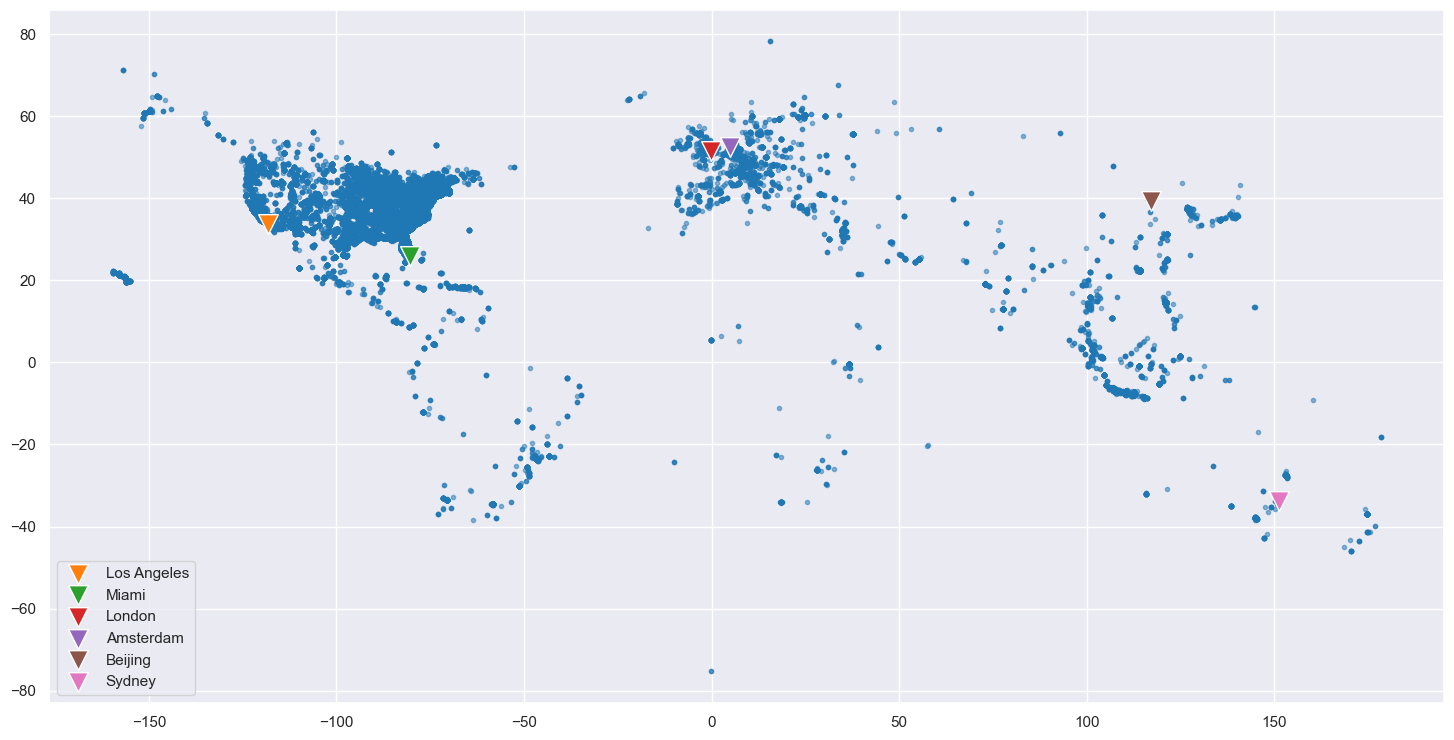

In [38]:
plt.figure(figsize=(18,9))
plt.scatter(X[:,0], X[:,1], marker='.', alpha=0.5)
for city, coords in offices.items():
    plt.scatter(*coords, marker='v', s=200, edgecolor='w', label=city)
plt.legend(loc='lower left')
plt.show()

In [39]:
def zoom_in(X, lonlat, *, square_side_km):
    """Функция возвращает чекины, находящиеся внутри квадрата 
    со стороной square_side_km километров, в центре которого
    (на пересечении диагоналей) стоит объект lonlat. """
    latlon = np.flip(lonlat)  # geodesic требует (широта, долгота)
    km_deg = geodesic(latlon, latlon + np.array([1,0])).km
    half_side_deg = square_side_km / km_deg / 2
    constraints = [(X[:,i] >= lonlat[i] - half_side_deg) 
                   & (X[:,i] <= lonlat[i] + half_side_deg)
                   for i in (0, 1)]
    return X[np.logical_and(*constraints)]

In [40]:
square_side_km = 100

In [41]:
zoom_in(X, offices['Beijing'], square_side_km=square_side_km)

array([[117.214389,  39.121079],
       [117.214389,  39.121079]])

In [42]:
del offices['Beijing']

In [43]:
banner_aes = dict(marker='s', s=90, c='w', edgecolor='k', alpha=0.8)
office_aes = dict(marker='*', s=500, c='gold', edgecolor='w', alpha=0.8)

***
## <a id='toc4_1_'></a>[__K-средних__](#toc0_)

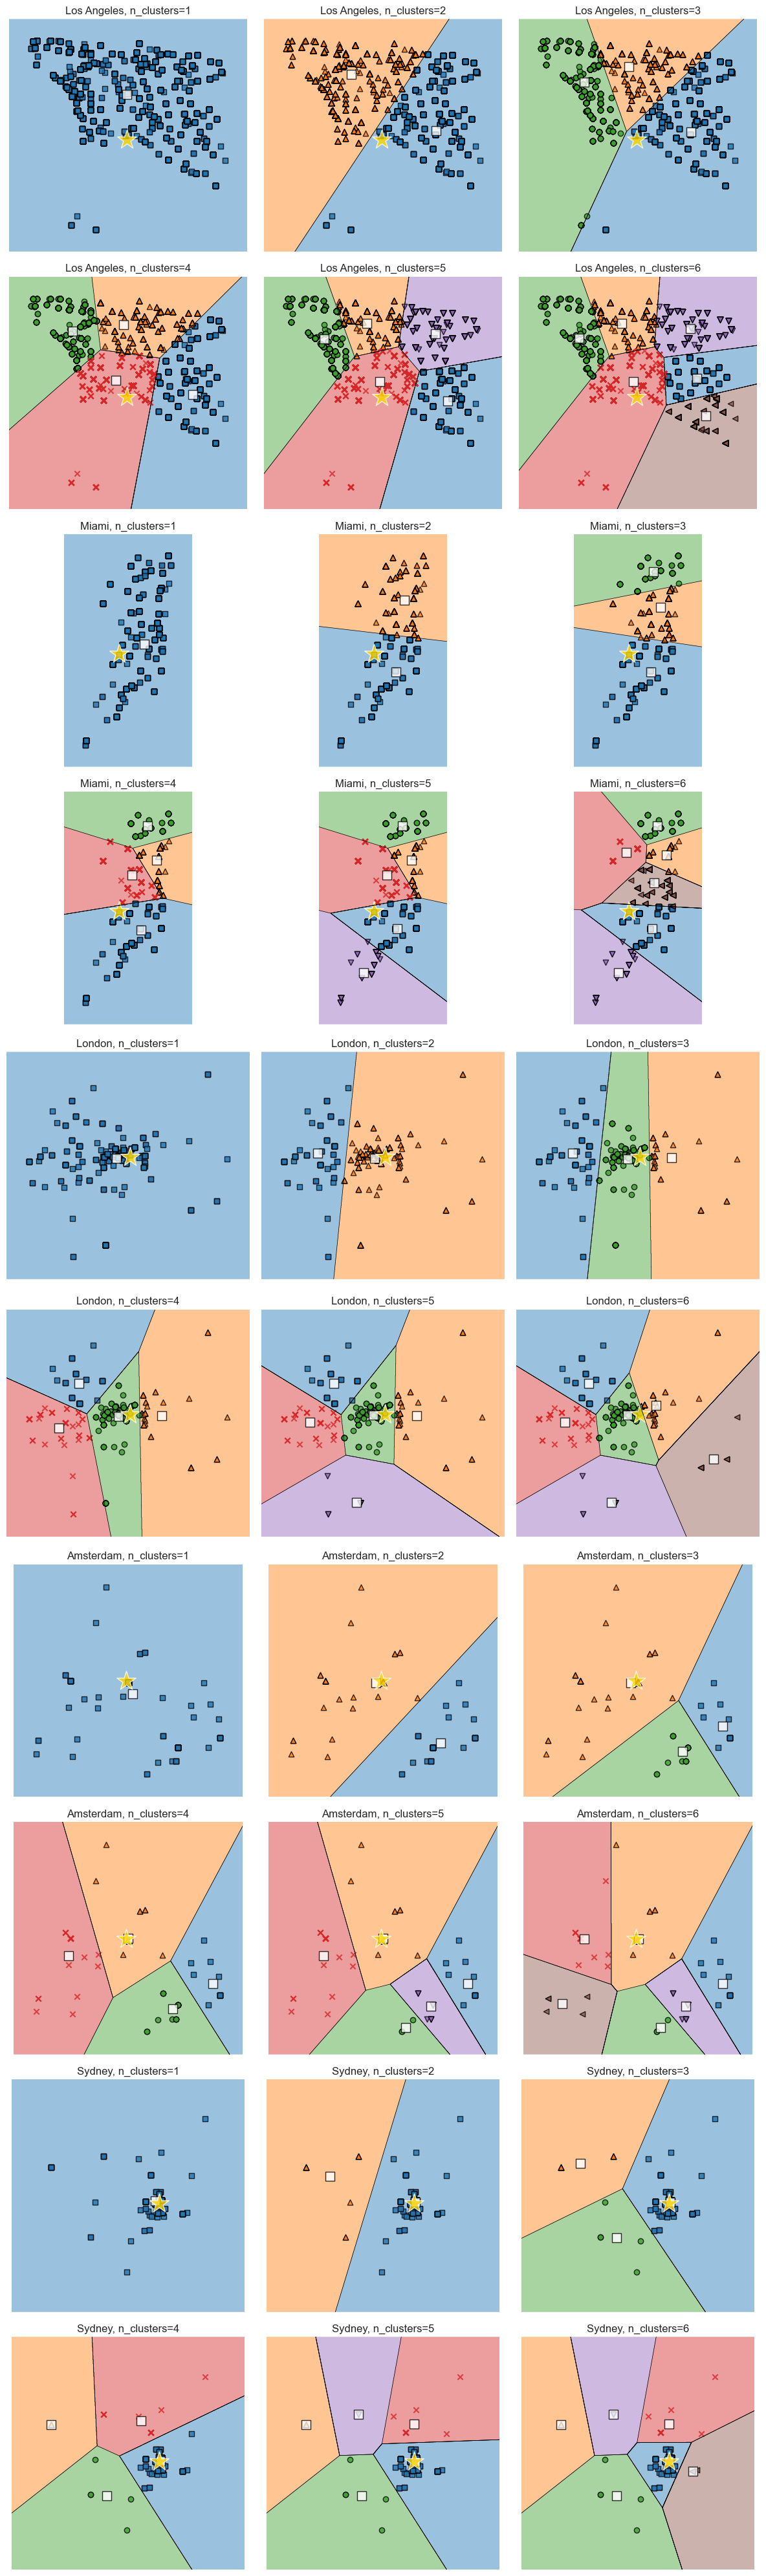

In [44]:
axs = plt.subplots(10, 3, figsize=(12,40))[1]
it = axs.flat

for (city, coords), n_clusters in product(offices.items(), range(1, 7)):
    checkins = zoom_in(X, coords, square_side_km=square_side_km)
    km = KMeans(n_clusters, n_init='auto', random_state=random_state)
    km.fit(checkins)    
    ax = next(it)
    
    # checkins clusters
    plot_decision_regions(checkins, km.labels_, km, 
                          ax=ax, zoom_factor=10, legend=0)
    
    # banners - centers of checkins clusters
    ax.scatter(*km.cluster_centers_.T, **banner_aes)
    
    # office location
    ax.scatter(*coords, **office_aes)
    
    ax.set_title(f'{city}, {n_clusters=}')
    ax.set_aspect('equal')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [45]:
n_banners = 6, 5, 4, 4, 0, 1
kmeans_suggests = dict(zip(offices_cities, n_banners))
kmeans_suggests

{'Los Angeles': 6,
 'Miami': 5,
 'London': 4,
 'Amsterdam': 4,
 'Beijing': 0,
 'Sydney': 1}

***
## <a id='toc4_2_'></a>[__DBSCAN__](#toc0_)

Покажем на примере агломерации Лос-Анжелеса, что DBSCAN не подходит для решения этой задачи ввиду высокой чувствительности метода к радиусу $\varepsilon$-окрестности и соответствующей непредсказуемости формы кластеров.

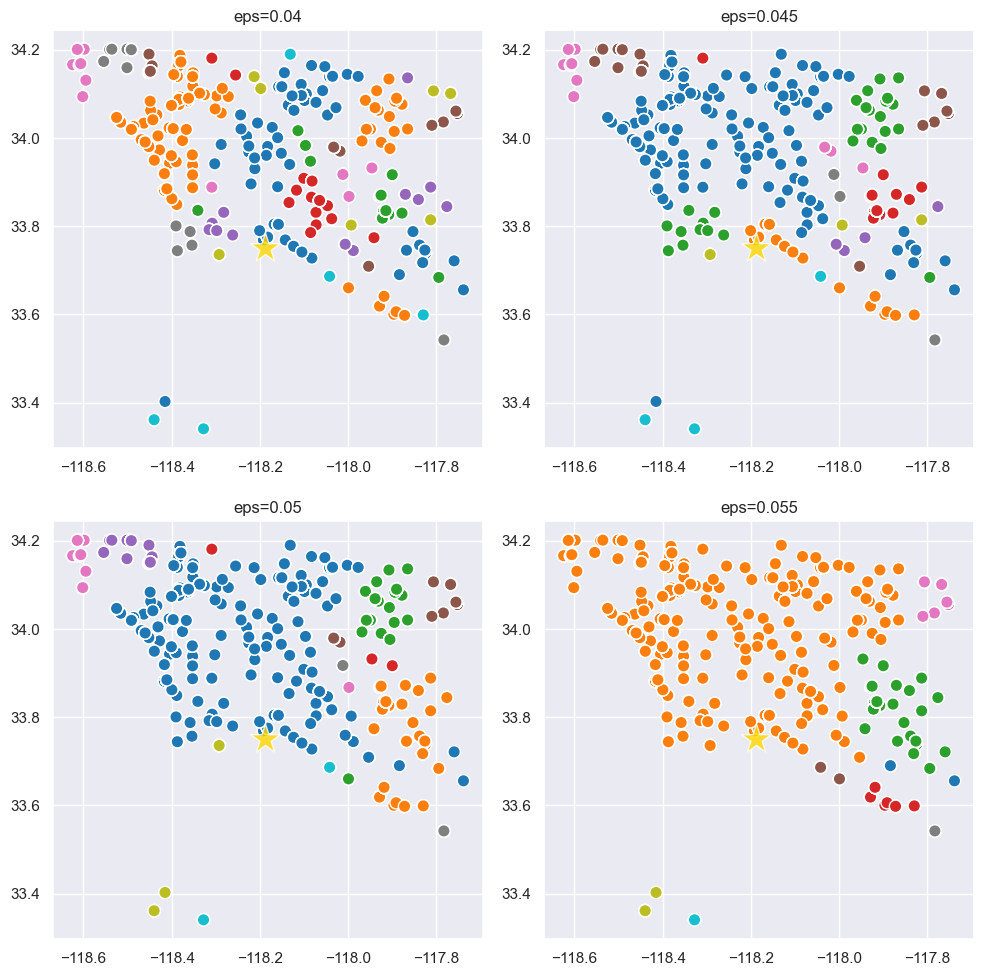

In [46]:
axs = plt.subplots(2, 2, figsize=(10,10))[1]
it = axs.flat
coords = offices['Los Angeles']
checkins = zoom_in(X, coords, square_side_km=square_side_km)

for eps in np.arange(4, 6, 0.5) / 100:
    dbscan = DBSCAN(eps).fit(checkins)
    ax = next(it)
    ax.scatter(*checkins.T, s=80, c=dbscan.labels_, 
               cmap='tab10', edgecolor='w')
    ax.scatter(*coords, **office_aes)  # office
    ax.set_title(f'{eps=}')
    ax.set_aspect('equal')
    
plt.tight_layout()
plt.show()

***
## <a id='toc4_3_'></a>[__MeanShift__](#toc0_)

[__sklearn.cluster.MeanShift__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn-cluster-meanshift)

* __`bandwidth`__ регулирует радиус поиска центроида кластера;
* __`bin_seeding=True`__: алгоритм инициализирует начальные точки в местах скопления объектов;
* __`min_bin_freq`__ регулирует минимальное число точек в кластере.

In [47]:
params_sets = [{'bandwidth': [0.1, 0.15, 0.2], 'min_bin_freq': [10, 20, 40]},
               {'bandwidth': [0.05, 0.1, 0.15], 'min_bin_freq': [5, 10, 15]}]

offices_adaptive = {city: {'coords': coords} for city, coords in offices.items()}

for city in offices_adaptive:
    offices_adaptive[city] |= params_sets[offices_cities.index(city) > 1]
    
print_black(offices_adaptive)

{
    "Los Angeles": {
        "coords": array([-118.18874, 33.751277]),
        "bandwidth": [0.1, 0.15, 0.2],
        "min_bin_freq": [10, 20, 40],
    },
    "Miami": {
        "coords": array([-80.324116, 25.867736]),
        "bandwidth": [0.1, 0.15, 0.2],
        "min_bin_freq": [10, 20, 40],
    },
    "London": {
        "coords": array([-0.075479, 51.503016]),
        "bandwidth": [0.05, 0.1, 0.15],
        "min_bin_freq": [5, 10, 15],
    },
    "Amsterdam": {
        "coords": array([4.885084, 52.378894]),
        "bandwidth": [0.05, 0.1, 0.15],
        "min_bin_freq": [5, 10, 15],
    },
    "Sydney": {
        "coords": array([151.205134, -33.868457]),
        "bandwidth": [0.05, 0.1, 0.15],
        "min_bin_freq": [5, 10, 15],
    },
}



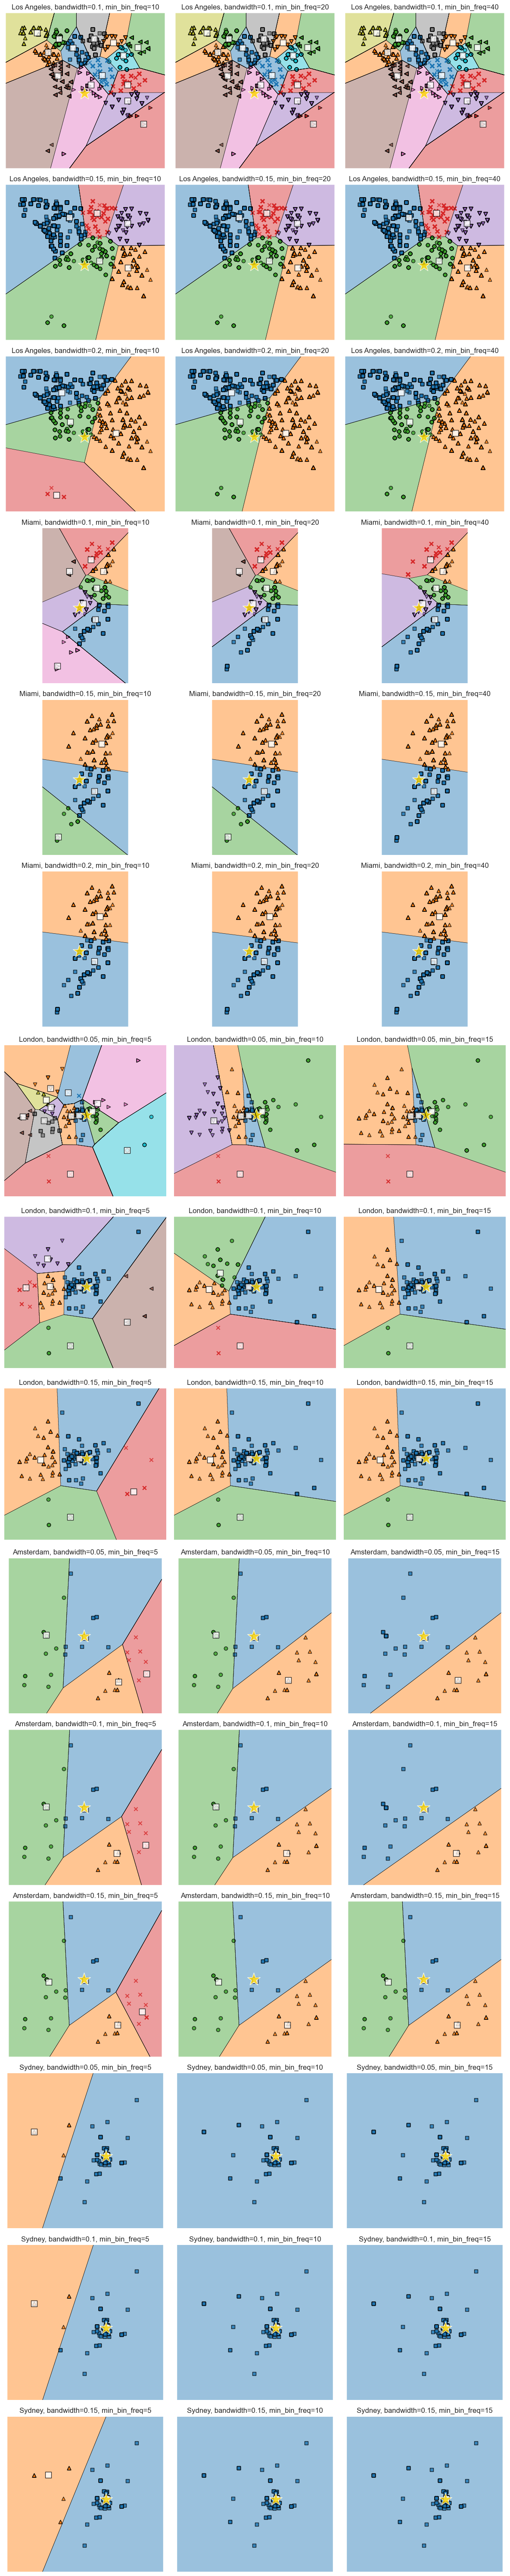

In [48]:
axs = plt.subplots(15, 3, figsize=(12,60))[1]
it = axs.flat

for city, params in offices_adaptive.items():
    checkins = zoom_in(X, params['coords'], square_side_km=square_side_km)
    params_grid = product(params['bandwidth'], params['min_bin_freq'])
    
    for bandwidth, min_bin_freq in params_grid:
        clustering = MeanShift(
            bandwidth=bandwidth,
            bin_seeding=True,
            min_bin_freq=min_bin_freq
        )
        clustering.fit(checkins)
        ax = next(it)
        
        # checkins clusters
        plot_decision_regions(checkins, clustering.labels_, clustering, 
                              ax=ax, zoom_factor=10, legend=0)
        
        # banners - centers of checkins clusters
        ax.scatter(*clustering.cluster_centers_.T, **banner_aes)
        
        # office location
        ax.scatter(*params['coords'], **office_aes)
        
        ax.set_title(f'{city}, {bandwidth=}, {min_bin_freq=}')
        ax.set_aspect('equal')
        ax.axis('off')
    
plt.tight_layout()
plt.show()

In [49]:
params = [(0.15, 10, 5), (0.1, 20, 6), (0.1, 10, 4), 
          (0.05, 5, 4), (0, 0, 0), (0.05, 10, 1)]

meanshift_suggests = {city: {'bandwidth': bandwidth, 
                             'min_bin_freq': min_bin_freq,
                             'n_banners': n_banners}
                      for city, (bandwidth, min_bin_freq, n_banners)
                      in zip(offices_cities, params)}

meanshift_suggests

{'Los Angeles': {'bandwidth': 0.15, 'min_bin_freq': 10, 'n_banners': 5},
 'Miami': {'bandwidth': 0.1, 'min_bin_freq': 20, 'n_banners': 6},
 'London': {'bandwidth': 0.1, 'min_bin_freq': 10, 'n_banners': 4},
 'Amsterdam': {'bandwidth': 0.05, 'min_bin_freq': 5, 'n_banners': 4},
 'Beijing': {'bandwidth': 0, 'min_bin_freq': 0, 'n_banners': 0},
 'Sydney': {'bandwidth': 0.05, 'min_bin_freq': 10, 'n_banners': 1}}